# Introduction (Himmelblau's function)



Let's use ``blop`` to minimize Himmelblau's function, which has four global minima:

In [1]:
import datetime
from bluesky.run_engine import RunEngine
from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from tiled.client import from_uri
from ophyd.utils import make_dir_tree# Constants
from tiled.server import SimpleTiledServer
from tiled.client import from_uri


SERVER_HOST_LOCATION = "http://localhost:8000"
DEFAULT_DB_TYPE = "local"
DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"# Initialize Tiled client

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)# Function to set up Bluesky environment

def setup_re_env(db_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return dict(RE=RE, db=tiled_client, bec=bec)# Initialize the environment
env = setup_re_env(db_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

Tiled version 0.1.0b21


/home/jmoylan1/miniconda3/envs/test_tiled_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, 'x2')

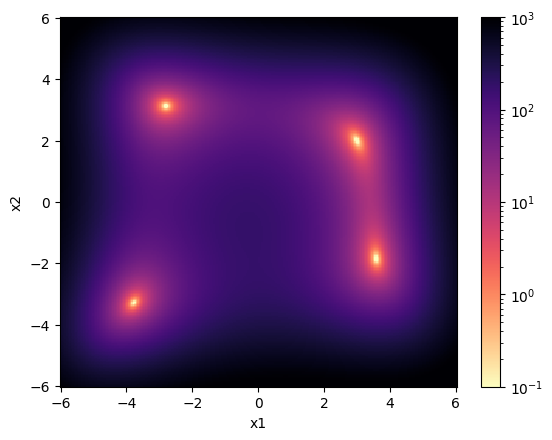

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from blop.utils import functions

x1 = x2 = np.linspace(-6, 6, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e3), cmap="magma_r")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

We also need to give the agent something to do. We want our agent to look in the feedback for a variable called 'himmelblau', and try to minimize it.

In [ ]:
from blop import Objective

objectives = [Objective(name="himmelblau", description="Himmeblau's function", target="min")]

In our digestion function, we define our objective as a deterministic function of the inputs:

In [ ]:
def digestion(df):
    for index, entry in df.iterrows():
        df.loc[index, "himmelblau"] = functions.himmelblau(entry.x1, entry.x2)

    return df

We then combine these ingredients into an agent, giving it an instance of ``TiledWriter`` so that it can see the output of the plans it runs.

In [ ]:
from blop import Agent

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    tiled=tiled,
)

Without any data, we can't make any inferences about what the function looks like, and so we can't use any non-trivial acquisition functions. Let's start by quasi-randomly sampling the parameter space, and plotting our model of the function:

In [ ]:
RE(agent.learn("quasi-random", n=36))
agent.plot_objectives()

To decide which points to sample, the agent needs an acquisition function. The available acquisition function are here:

In [ ]:
agent.all_acqfs

Now we can start to learn intelligently. Using the shorthand acquisition functions shown above, we can see the output of a few different ones:

In [ ]:
agent.plot_acquisition(acqf="qei")

To decide where to go, the agent will find the inputs that maximize a given acquisition function:

In [ ]:
agent.ask("qei", n=1)

We can also ask the agent for multiple points to sample and it will jointly maximize the acquisition function over all sets of inputs, and find the most efficient route between them:

In [ ]:
res = agent.ask("qei", n=8, route=True)
agent.plot_acquisition(acqf="qei")
plt.scatter(res["points"]["x1"], res["points"]["x2"], marker="d", facecolor="w", edgecolor="k")
plt.plot(res["points"]["x1"], res["points"]["x2"], color="r")

All of this is automated inside the ``learn`` method, which will find a point (or points) to sample, sample them, and retrain the model and its hyperparameters with the new data. To do 4 learning iterations of 8 points each, we can run

In [ ]:
RE(agent.learn("qei", n=4, iterations=8))

Our agent has found all the global minima of Himmelblau's function using Bayesian optimization, and we can ask it for the best point: 

In [ ]:
agent.plot_objectives()
print(agent.best)

In [ ]:
tiled_server.close()